## Preliminary Analysis of Dominik's 93 Colour Patch Comparison Data

2022-Jan-28  
Ariel Zeleznikow-Johnston

In [187]:
# hardcoded values
n.compare = 320
cor_threshold = 0.5
n.stim = 93

In [62]:
library(tidyverse)
install.packages("ramify")
library(dplyr)
library(ggplot2)
install.packages("reshape2")
library(viridis)
library(MASS)
install.packages("hrbrthemes")
library(scales)
library(broom)
install.packages("pglm")

package 'ramify' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\RtmpqIflUh\downloaded_packages
package 'reshape2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\RtmpqIflUh\downloaded_packages
package 'hrbrthemes' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\RtmpqIflUh\downloaded_packages


also installing the dependencies 'rbibutils', 'miscTools', 'sandwich', 'bdsmatrix', 'Rdpack', 'maxLik', 'plm', 'statmod'




package 'rbibutils' successfully unpacked and MD5 sums checked
package 'miscTools' successfully unpacked and MD5 sums checked
package 'sandwich' successfully unpacked and MD5 sums checked
package 'bdsmatrix' successfully unpacked and MD5 sums checked
package 'Rdpack' successfully unpacked and MD5 sums checked
package 'maxLik' successfully unpacked and MD5 sums checked
package 'plm' successfully unpacked and MD5 sums checked
package 'statmod' successfully unpacked and MD5 sums checked
package 'pglm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\zelez\AppData\Local\Temp\RtmpqIflUh\downloaded_packages


### Loading Data

In [3]:
# matching regex of any amount of characters then followed by .csv
files <- list.files(path="./data", pattern="*.csv", full.names=TRUE)
filesizes <- file.size(files)

# individual participant files use a unique ID to mark which colour pairs they saw
truthColourTableColumnNames <- c("r1", "g1", "b1", "r2", "g2", "b2")
truthColourTable <- read.csv("./colourcodes/colourcodes.csv", header=F)
names(truthColourTable) <- truthColourTableColumnNames

# not sure what the point of this is...?
files <- files[-(which(filesizes < 4))]

pilotdata <- sapply(files, read.csv, simplify=FALSE) %>% bind_rows(.id = "fileId")

In [4]:
# changing realcomparison from zero-indexed to one-indexed

participantsIDFrame <- data.frame(unique(pilotdata$participant))

pilotdata <- pilotdata %>% arrange("participant")

In [5]:
# variables of interest from collected data
trial_vars<- c( "participant", "practice_comparison", "pracsimilarity", "realcomparison", "similarity", "response_time", "trials_2.thisN") 
catch_vars<- c("participant", "catch_response_time", "catchnumberprac", "catchpracsimilarity", "catchnumber", "catchsimilarity", "catchRT", "catchtrialorder")
trialdata <- (pilotdata %>% filter(!is.na(realcomparison)))[trial_vars] # no catch trials
catchdata <- (pilotdata %>% filter(!is.na(catchnumber)))[catch_vars] # no main trials
trialdata = rename(trialdata, dissimilarity = similarity)

trialdata$realcomparison <- trialdata$realcomparison + 1 # fixing the indexing?

rgb2hex <- function(r, g, b) {rgb(r, g, b, maxColorValue = 255)}

In [27]:
# getting the colour pair comparison information

# compartmentalising the two dots presented to participants
firstColourSet <- truthColourTable[,truthColourTableColumnNames[1:3]]
secondColourSet <- truthColourTable[,truthColourTableColumnNames[4:6]]

names(firstColourSet) <- names(secondColourSet) <- c("r", "g", "b")

#conversion of 3 RGB columns in both colour tables to HEX for easier manipulation
firstColourSetHEX <- apply(firstColourSet, 1, function (x) rgb2hex(x[1], x[2], x[3]))
secondColourSetHEX <- apply(secondColourSet, 1, function (x) rgb2hex(x[1], x[2], x[3]))
                            
#conversion of 3 RGB columns in both colour tables to HEX for easier manipulation
firstColourSetHEX <- apply(firstColourSet, 1, function (x) rgb2hex(x[1], x[2], x[3]))
secondColourSetHEX <- apply(secondColourSet, 1, function (x) rgb2hex(x[1], x[2], x[3]))

colourSetHEX <- data.frame(firstColour = firstColourSetHEX, secondColour = secondColourSetHEX)


### Cleaning Data

##### Catch Trials

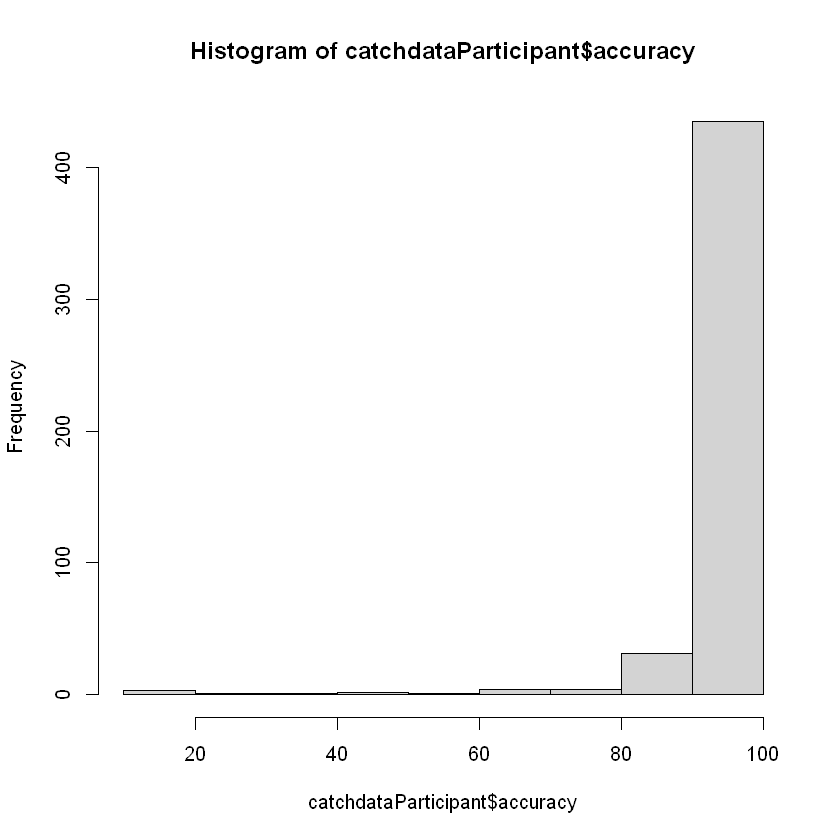

In [29]:
# catch trial scoring
#hist(catchdataParticipant$accuracy)


In [48]:
# assess whether participants passed
catch.assess <- function(catchdata){
    catchdata <- catchdata %>% mutate(is_valid_catch_response = if_else(catchnumber == catchsimilarity, 1, 0), is_invalid_catch_response = if_else(catchnumber != catchsimilarity, 1, 0))
    catchdataParticipant <- catchdata %>% group_by(participant) %>% 
      summarise(correct_responses=sum(is_valid_catch_response), incorrect_responses = sum(is_invalid_catch_response))

    catchdataParticipant$total <- catchdataParticipant$correct_responses + catchdataParticipant$incorrect_responses
    catchdataParticipant$accuracy <- (catchdataParticipant$correct_responses/catchdataParticipant$total) * 100
    return(catchdataParticipant)
}

# remove participants who scored below a certain threshold
catch.remove <- function(catchdata, trialdata, threshold){
    catch.participant <- catch.assess(catchdata)
    passed <- subset(catch.participant, accuracy >= threshold)$participant
    clean <- subset(trialdata, trialdata$participant %in% passed)
    return(clean)
}


In [50]:
# clean the trial data
clean.data <- catch.remove(catchdata,trialdata,80) # using 80% threshold

##### Within-subject double pass consistency

In [99]:
# each participant should have completed 320 trials
count.remove <- function(data, threshold){
    count <- data %>% count(participant)
    passed <- subset(count, n == threshold)$participant
    clean <- subset(data, participant %in% passed)
    return(clean)
}

clean.data <- count.remove(clean.data,n.compare)

##### Within-subject double pass consistency

In [118]:
double.pass.check <- function(data){
    v1 <- data$dissimilarity[1:(n.compare/2)]
    v2 <- data$dissimilarity[(n.compare/2+1):n.compare]
    return(cor(v1,v2))
}

pass.remove <- function(data, threshold=cor_threshold){
    IDs <- unique(data$participant)
    passed <- vector()
    for(id in IDs){
        tryCatch(
            {
                if(double.pass.check(subset(data, participant == id)) >= threshold){
                    passed <- c(passed,id)
                }
            },
            error=function(cond){
                message(paste("Something went wrong with correlations for participant:",id))
            }
        )
        
    }
    clean <- subset(data, participant %in% passed)
    return(clean)
}

clean.data <- pass.remove(clean.data)

Warning message in cor(v1, v2):
"the standard deviation is zero"
Something went wrong with correlations for participant: 60fdee1f5bb38a56c58631bc



### Descriptive plots & statistics

##### Matrix Visualisations

Setting up the matrix

In [127]:
# read in the colour comparison truth table
colourSetHEX <- data.frame(firstColour = firstColourSetHEX, secondColour = secondColourSetHEX)

rowsTotalSetHEX <- rbind(data.frame(colour = firstColourSetHEX), data.frame(colour = secondColourSetHEX)) %>% group_by_all %>% count

# preliminary check that the data has been read in correctly
countOfUniqueRowsFirstSet <- length(unique(firstColourSetHEX))
countOfUniqueRowsSecondSet <- length(unique(secondColourSetHEX))
countOfUniqueRowsTotalSet <- length(rowsTotalSetHEX$colour)

In [163]:
# set lower triangle of matrix to NA - this gives heatmap its unique upper triangle
upperTriangularMatrix <- upper.tri(matrix(1, ncol = countOfUniqueRowsTotalSet, nrow = countOfUniqueRowsTotalSet), 
                              diag = FALSE)
upperTriangularMatrix[upperTriangularMatrix == 1] <- NA
color.mat.df <- data.frame(upperTriangularMatrix)
color.mat <- upperTriangularMatrix

#head(uniqueColourCountDF)

In [164]:
# setting all give colours as both row and column names
colnames(color.mat.df) <- rownames(color.mat.df) <- rowsTotalSetHEX$colour
colnames(color.mat) <- rownames(color.mat) <- rowsTotalSetHEX$colour

Matrix plot of group mean for each comparison

In [165]:
# get mean dissimilarity for each colour comparison
group.mean <- clean.data %>% group_by(realcomparison) %>% summarise(across(dissimilarity, mean, na.rm = TRUE))

In [195]:
gp.mean.data <- colourSetHEX
gp.mean.data$value <- group.mean$dissimilarity

In [196]:
head(gp.mean.data)

,firstColour,secondColour,value
,<chr>,<chr>,<dbl>
1,#E088A1,#E088A1,0.4090909
2,#E088A1,#C4577A,2.5714286
3,#E088A1,#B06079,2.5000000
4,#E088A1,#9C1C53,3.2000000
5,#E088A1,#7C3D4E,3.6562500
6,#E088A1,#7D0B45,3.5454545


In [237]:
# fill matrix

matrix.df.fill <- function(data,matrix.df){
    for(i in 1:nrow(data)){
        #print(i)
        row <- data[i,]
        #print(matrix.df[row$firstColour,row$secondColour])
        matrix.df[row$firstColour,row$secondColour] <- row$value
        matrix.df[row$secondColour,row$firstColour] <- row$value # symmetric
        #print(matrix.df[row$firstColour,row$secondColour])
    }
    return(matrix.df)
}

In [238]:
group.mean.mat.df <- matrix.df.fill(gp.mean.data,color.mat.df)

In [239]:
group.mean.mat.df

,#010300,#022C88,#02529A,#032040,#03406F,#034E49,#086E79,#09384C,#0A3B38,#0C4FA2,⋯,#F4D000,#F699A1,#F6F7F1,#FAAF99,#FAC88D,#FB702E,#FBA628,#FBEC77,#FCDD2A,#FF8F00
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
#010300,0.000000,5.3000000,5.9000000,3.8214286,5.1666667,4.733333,5.1176471,3.75000000,4.0294118,5.3500000,⋯,6.500000,6.500000,6.500000,6.605263,6.333333,6.833333,6.675000,6.500000,5.733333,6.619048
#022C88,5.300000,0.1956522,1.1578947,2.5833333,0.9375000,3.181818,2.5000000,2.56250000,4.9230769,1.6000000,⋯,6.058824,6.411765,6.535714,5.800000,6.000000,6.545455,6.000000,5.928571,5.657895,6.088235
#02529A,5.900000,1.1578947,0.7352941,2.9210526,1.5714286,3.545455,2.0750000,2.94444444,3.2500000,0.5000000,⋯,6.437500,6.176471,6.035714,5.472222,6.576923,6.092593,6.538462,6.038462,6.666667,5.631579
#032040,3.821429,2.5833333,2.9210526,0.8076923,1.7692308,3.472222,2.8750000,0.83333333,2.2000000,3.1578947,⋯,6.562500,5.875000,6.136364,6.352941,6.033333,6.229167,6.025000,6.058824,6.041667,6.263158
#03406F,5.166667,0.9375000,1.5714286,1.7692308,0.7941176,3.277778,2.8461538,1.45000000,3.1363636,1.7812500,⋯,6.289474,6.100000,5.928571,5.788462,6.384615,6.208333,6.200000,5.961538,5.625000,6.000000
#034E49,4.733333,3.1818182,3.5454545,3.4722222,3.2777778,1.045455,2.1153846,2.12500000,0.8000000,2.9000000,⋯,6.500000,6.055556,6.342105,6.406250,5.307692,5.750000,5.970588,5.785714,5.625000,6.343750
#086E79,5.117647,2.5000000,2.0750000,2.8750000,2.8461538,2.115385,0.5294118,2.87500000,3.7812500,2.3333333,⋯,5.979167,5.950000,5.000000,5.600000,4.625000,6.631579,6.194444,5.214286,5.200000,6.227273
#09384C,3.750000,2.5625000,2.9444444,0.8333333,1.4500000,2.125000,2.8750000,0.09090909,1.3000000,2.8076923,⋯,6.400000,6.236842,5.117647,6.218750,5.750000,6.023810,6.307692,6.125000,6.088235,6.000000
#0A3B38,4.029412,4.9230769,3.2500000,2.2000000,3.1363636,0.800000,3.7812500,1.30000000,0.5714286,3.5833333,⋯,5.300000,6.607143,6.166667,6.038462,6.200000,6.346154,6.266667,5.625000,5.800000,6.250000
